# **Solution to PSet 5**

> provided and graded by Xuntao Wu

[:material-download: Download this notebook](./sol5.ipynb)

In [1]:
# Import required libraries
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from datetime import datetime
from pytz import timezone

# Install and import QuTiP if needed
try:
    from qutip import *
except ImportError:
    %pip install qutip
    from qutip import *

# Configure matplotlib for LaTeX rendering
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{physics}",
        "font.family": "serif",
    }
)
%config InlineBackend.figure_format = 'svg'

# Print version and execution time info
print(f"QuTiP version: {qutip.__version__}")
print(
    "Time of execution: ",
    datetime.now(timezone("America/Chicago")).strftime("%Y-%m-%d %H:%M:%S"),
)

QuTiP version: 5.1.1
Time of execution:  2025-05-03 16:52:10


In [ ]:
import datetime
from qutip.qip.operations import cphase

# import qutip.logging_utils as logging
import logging

logger = logging.getLogger("qutip")
log_level = logging.INFO
# #QuTiP control modules
import qutip.control.pulseoptim as cpo

## **Problem 5-1 [21 points]** 

Optimal control of an NV-center

Consider an NV with two carbon-13 nuclei nearby with energy levels of the electron spin system identical to that shown in Extended Data Figure 6 of Waldherr et al. You have to consider only the 4 levels arising from the two carbon atoms (disregard the nitrogen nuclear spin). Here, we will use QuTiP to implement a simplified implementation of quantum optimal control similar to what was done in the paper.

### **a. [3 points]**  

To begin, use QuTiP to implement the natural CC-$2\pi$ gate where we drive resonantly on the $\ket{011} \rightarrow \ket{111}$ ($\ket{NV, C_1, C_2}$) transition assuming a Rabi frequency of 0.1 MHz and the energy splittings from the paper.

---

The $CC-2\pi$ gate can be expressed as: $-\mathbb{1}\otimes\ket{11}\bra{11}+\mathbb{1}\otimes\left( \mathbb{1} - \ket{11}\bra{11} \right)$

In [ ]:
def CC2Pi():
    mat = np.zeros((8, 8), dtype=complex)
    for i in np.arange(0, 8):
        mat[i, i] = 1.0
    mat[3, 3] = mat[7, 7] = -1
    return Qobj(mat, dims=[[2, 2, 2], [2, 2, 2]])


psi_0 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))  # NV, C1, C2 basis ordering
psi_1 = tensor(basis(2, 0), basis(2, 0), basis(2, 1))
psi_2 = tensor(basis(2, 0), basis(2, 1), basis(2, 0))
psi_3 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))

S000 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))  # all states in basis notation
S001 = tensor(basis(2, 0), basis(2, 0), basis(2, 1))
S010 = tensor(basis(2, 0), basis(2, 1), basis(2, 0))
S011 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))
S100 = tensor(basis(2, 1), basis(2, 0), basis(2, 0))
S101 = tensor(basis(2, 1), basis(2, 0), basis(2, 1))
S110 = tensor(basis(2, 1), basis(2, 1), basis(2, 0))
S111 = tensor(basis(2, 1), basis(2, 1), basis(2, 1))

print(np.real(np.around(CC2Pi().full(), 2)))  # print out target matrix

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]


The Hamiltonian in some fixed rotating frame is $H = \Delta S_Z + \sum_i A_i I_{iZ}S_Z + H_{\text{drive}}$, where I choose $S_Z$ as `diag(0,-1)` and $I_{IZ}$ as `diag(1/2,-1/2)`. $\Delta$ depends on driving frequency.

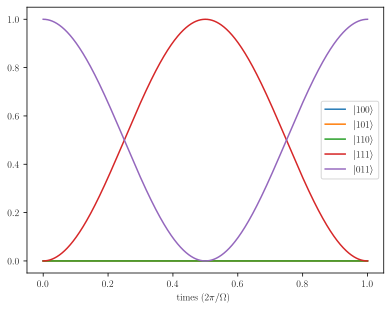

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.    0.    0.    0.    0.5   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.5   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.5   0.    0.    0.   -5.02  0.    0.    0.  ]
 [ 0.    0.5   0.    0.    0.   -4.13  0.    0.  ]
 [ 0.    0.    0.5   0.    0.    0.   -0.89  0.  ]
 [ 0.    0.    0.    0.5   0.    0.    0.    0.  ]]


In [4]:
########### Initial values ####################################
# Here I will parametrize detuning with respect to omega1
omega1 = 0.1e6
E2 = 89e3 / omega1  # between same spin up down for eg: b/n |100> and |101>
E1 = 413e3 / omega1 - E2  # between two nuclear spins eg: b/n |110> and |101>
omega = 1
###############################################################

#######  Defining detuning when drive is resonant with |1,1,1> state ######################
det100 = -2 * E2 - E1
det101 = -E2 - E1
det110 = -E2
det111 = 0
############################################################################################

########## Initialization ####################
psi0 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))
################################################

##### define the detuning of the states ########################
population_100 = tensor(
    basis(2, 1) * basis(2, 1).dag(),
    basis(2, 0) * basis(2, 0).dag(),
    basis(2, 0) * basis(2, 0).dag(),
)  # state |1,0,0>
population_101 = tensor(
    basis(2, 1) * basis(2, 1).dag(),
    basis(2, 0) * basis(2, 0).dag(),
    basis(2, 1) * basis(2, 1).dag(),
)  # state |1,0,1>
population_110 = tensor(
    basis(2, 1) * basis(2, 1).dag(),
    basis(2, 1) * basis(2, 1).dag(),
    basis(2, 0) * basis(2, 0).dag(),
)  # state |1,1,0>
population_111 = tensor(
    basis(2, 1) * basis(2, 1).dag(),
    basis(2, 1) * basis(2, 1).dag(),
    basis(2, 1) * basis(2, 1).dag(),
)  # state |1,1,1>
H = (
    det100 * population_100
    + det101 * population_101
    + det110 * population_110
    + det111 * population_111
)
################################################################

################### Define the allowed transitions ##################################
# only electronic spin can change, nuclear spins will remain the same
transition1 = (
    tensor(basis(2, 1), basis(2, 0), basis(2, 0))
    * tensor(basis(2, 0), basis(2, 0), basis(2, 0)).dag()
)  # |1,0,0><0,0,0|
transition2 = (
    tensor(basis(2, 1), basis(2, 1), basis(2, 0))
    * tensor(basis(2, 0), basis(2, 1), basis(2, 0)).dag()
)  # |1,1,0><0,1,0|
transition3 = (
    tensor(basis(2, 1), basis(2, 0), basis(2, 1))
    * tensor(basis(2, 0), basis(2, 0), basis(2, 1)).dag()
)  # |1,0,1><0,0,1|
transition4 = (
    tensor(basis(2, 1), basis(2, 1), basis(2, 1))
    * tensor(basis(2, 0), basis(2, 1), basis(2, 1)).dag()
)  # |1,1,1><0,1,1|
H_int_x = (
    omega
    / 2
    * (
        transition1
        + transition1.dag()
        + transition2
        + transition2.dag()
        + transition3
        + transition3.dag()
        + transition4
        + transition4.dag()
    )
)
#####################################################################################


################## Hamiltonian #############################
# This includes detuning part and the driving part
H_tot = H + H_int_x
#############################################################

################## Time and Evolution #######################
tevol = 2 * np.pi / omega
times = np.linspace(0, tevol, 1000)
results = sesolve(
    H_tot,
    psi0,
    times,
    e_ops=[
        population_100,
        population_101,
        population_110,
        population_111,
        psi0 * psi0.dag(),
    ],
)
#############################################################


#################### Plotting #############################
plt.plot(times / (2 * np.pi / omega), results.expect[0], label=r"$\ket{100}$")
plt.plot(times / (2 * np.pi / omega), results.expect[1], label=r"$\ket{101}$")
plt.plot(times / (2 * np.pi / omega), results.expect[2], label=r"$\ket{110}$")
plt.plot(times / (2 * np.pi / omega), results.expect[3], label=r"$\ket{111}$")
plt.plot(times / (2 * np.pi / omega), results.expect[4], label=r"$\ket{011}$")
plt.legend()
plt.xlabel(r"times ($2\pi/\Omega$)")
plt.show()


print(H_tot)

Here we see it acts as perfect 2pi pulse. But this assumes that there is perfect initialization and also that other states are empty, which is not the case in general while manipulating the system. If we have an equal super position states in the ground state, this will not be a perfect CC2pi gate as can be seen below.

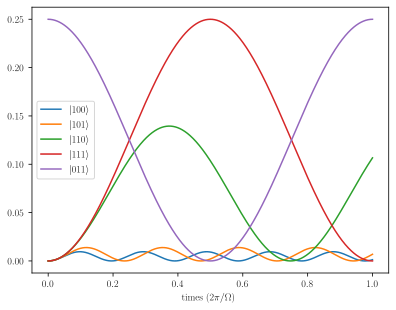

In [ ]:
######## New inital state #####################
psi1 = 0.5 * (
    tensor(basis(2, 0), basis(2, 1), basis(2, 1))
    + tensor(basis(2, 0), basis(2, 1), basis(2, 0))
    + tensor(basis(2, 0), basis(2, 0), basis(2, 1))
    + tensor(basis(2, 0), basis(2, 0), basis(2, 0))
)
################################################

################## Time and Evolution #######################
results = sesolve(
    H_tot,
    psi1,
    times,
    e_ops=[
        population_100,
        population_101,
        population_110,
        population_111,
        psi0 * psi0.dag(),
    ],
)
#############################################################

#################### Plotting #############################
plt.plot(times / (2 * np.pi / omega), results.expect[0], label=r"$\ket{100}$")
plt.plot(times / (2 * np.pi / omega), results.expect[1], label=r"$\ket{101}$")
plt.plot(times / (2 * np.pi / omega), results.expect[2], label=r"$\ket{110}$")
plt.plot(times / (2 * np.pi / omega), results.expect[3], label=r"$\ket{111}$")
plt.plot(times / (2 * np.pi / omega), results.expect[4], label=r"$\ket{011}$")
plt.legend()
plt.xlabel(r"times ($2\pi/\Omega$)")
plt.show()
###########################################################

In [ ]:
################## Time and Evolution #######################
results = sesolve(H_tot, psi1, times)
#############################################################

print(results.states[-1])

print("\n")

final_state_evolved = results.states[-1]

print(CC2Pi() * psi1)

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.47596726-1.48963130e-01j]
 [ 0.461333  -1.74005781e-01j]
 [ 0.12987708-3.55657010e-01j]
 [-0.50000004+0.00000000e+00j]
 [ 0.00223423-3.54976204e-02j]
 [ 0.03297507-7.62003594e-02j]
 [-0.11061755-3.07252066e-01j]
 [ 0.        -1.19300933e-12j]]


Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.5]
 [ 0.5]
 [ 0.5]
 [-0.5]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]]


This will be much more clear if we look at the final unitary given by this hamiltonian

In [ ]:
################## Time Evolution #######################
results = sesolve(H_tot, tensor(qeye(2), qeye(2), qeye(2)), times)
#############################################################
# here by feeding sesolve a unitary (the identity matrix) it solves the Schrodinger operator equation to find
# the unitary that describes the full time evolution under our Hamiltonian for the given times vector
results.states[-1].tidyup(1e-1)

final_unitary = results.states[-1]

# final_unitary.tidyup(1e-1) # you can print this matrix out, which will give you the following

$$
\left(\begin{array}{cc}(0.952-0.298j) & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & (0.923-0.348j) & 0 & 0 & 0 & -0.152j & 0 & 0\\0 & 0 & (0.260-0.711j) & 0 & 0 & 0 & (-0.221-0.615j) & 0\\0 & 0 & 0 & -1.000 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & (0.907+0.415j) & 0 & 0 & 0\\0 & -0.152j & 0 & 0 & 0 & (0.378+0.911j) & 0 & 0\\0 & 0 & (-0.221-0.615j) & 0 & 0 & 0 & (0.654+0.383j) & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.000\end{array}\right)
$$

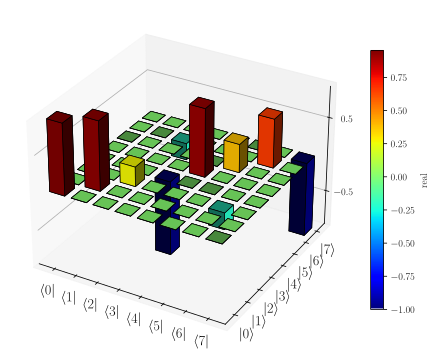

In [8]:
# Visualize
matrix_histogram(final_unitary);

We want 2pi only on $\ket{011}$ state, but this will off resonantly excite other states too leading to this being not a CC2pi unitary

### **b. [3 points]**  

Next, assume that we drive the system with a frequency fixed at the center of the 4 transition frequencies with complete control of the amplitude and phase of the applied microwave field for arbitrary slices of time. Formulate the Hamiltonian in the optimal control framework as  $\hat{H}_{\text{total}} = \hat{H}_{\text{drift}} + \sum_i \hat{H}_{i, \text{control}}$.

---

In [ ]:
############ New detuning based on new pulse position between 4 resonances###################
det100 = -E1 / 2 - E2
det101 = -E1 / 2
det110 = E1 / 2
det111 = E1 / 2 + E2
#########################################################################

############### Drift hamiltonian #######################################
H_d = (
    det100 * population_100
    + det101 * population_101
    + det110 * population_110
    + det111 * population_111
)
#########################################################################

######################### Control hamiltonian #############################
# Pulse phase will change relative amplitude of sigma_x and sigma_y
H_int_y = (
    omega
    / 2
    * (
        1j * transition1
        - 1j * transition1.dag()
        + 1j * transition2
        - 1j * transition2.dag()
        + 1j * transition3
        - 1j * transition3.dag()
        + 1j * transition4
        - 1j * transition4.dag()
    )
)
H_c = [H_int_x, H_int_y]
############################################################################

######################### Unitaries #######################################
# start point for the gate evolution
U_0 = tensor(qeye(2), qeye(2), qeye(2))
# target unitary
U_targ = tensor(
    qeye(2), cphase(np.pi)
)  # same as CC2Pi() but different coding structure
############################################################################

### **c. [3 points]**  

Use quantum optimal control to optimize for a unitary which is closest to the desired CC-$2\pi$ gate using the same total timescale as the resonant gate implemented in part a.

---

In [ ]:
#################### optimization parameters ###############################
# Number of time slots
n_ts = 30
# Time allowed for the evolution
evo_time = 1 * tevol

# Fidelity error target
fid_err_targ = 1e-15
# Maximum iterations for the optisation algorithm
max_iter = 2600
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-28

# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "RND"
############################################################################

########################### optimization ##################################
result = cpo.optimize_pulse_unitary(
    H_d,
    H_c,
    U_0,
    CC2Pi(),
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    min_grad=min_grad,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    out_file_ext=None,
    init_pulse_type=p_type,
    pulse_scaling=1,
    log_level=log_level,
    gen_stats=True,
    optim_method="LBFGSB",
)
############################################################################

#################### Result reporting ######################################
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print(
    "Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time))
)

INFO:qutip_qtrl.dynamics:Setting memory optimisations for level 0
INFO:qutip_qtrl.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip_qtrl.dynamics:phased dynamics generator caching True
INFO:qutip_qtrl.dynamics:propagator gradient caching True
INFO:qutip_qtrl.dynamics:eigenvector adjoint caching True
INFO:qutip_qtrl.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -2.51  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -1.62  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.62  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    2.51]]
Control 1 Hamiltoni


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:02.471120
Wall time computing Hamiltonians: 0:00:00.113641 (4.60%)
Wall time computing propagators: 0:00:01.922515 (77.80%)
Wall time computing forward propagation: 0:00:00.044327 (1.79%)
Wall time computing onward propagation: 0:00:00.045396 (1.84%)
Wall time computing gradient: 0:00:00.256455 (10.38%)

**** Iterations and function calls ****
Number of iterations: 885
Number of fidelity function calls: 940
Number of times fidelity is computed: 940
Number of gradient function calls: 940
Number of times gradients are computed: 940
Number of times timeslot evolution is recomputed: 940

**** Control amplitudes ****
Number of control amplitude updates: 939
Mean number of updates per iteration: 1.0610169491525423
Number of timeslot values changed: 28170
Mean number of timeslot changes per update: 30.0
Number of amplitude values changed:

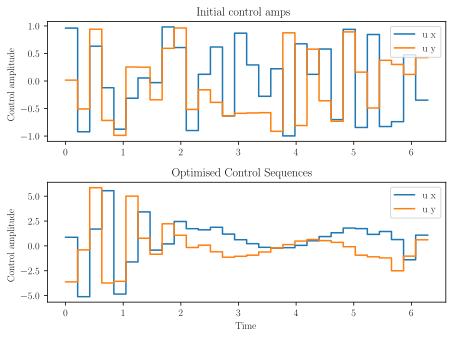

In [ ]:
####### Plot the control pulse sequence ################

labels = ["u_x", "u_y"]
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
# ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for k in range(len(H_c)):
    ax1.step(
        result.time,
        np.hstack((result.initial_amps[:, k], result.initial_amps[-1, k])),
        where="post",
        label=labels[k],
    )
ax1.legend()

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for k in range(len(H_c)):
    ax2.step(
        result.time,
        np.hstack((result.final_amps[:, k], result.final_amps[-1, k])),
        where="post",
        label=labels[k],
    )
ax2.legend()
plt.tight_layout()
plt.show()

In [42]:
###################### Checking the final unitary ###############
print("Target unitary")
print(U_targ)
print("\n")
print("optimized unitary")

# 1j * result.evo_full_final.tidyup(1.0e-1) # you can print this out
# Here I am multiplying an overall phase to the unitary to make the comparison clearer
#################################################################

Target unitary
Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  0.  0.  0. -1.]]


optimized unitary


$$
\left(\begin{array}{cc}(0.942+0.313j) & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & (0.983+0.122j) & 0 & 0 & 0 & 0.130 & 0 & 0\\0 & 0 & (0.924-0.381j) & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & -0.999 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & (0.960-0.253j) & 0 & 0 & 0\\0 & -0.113j & 0 & 0 & 0 & (0.800+0.585j) & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & (0.935-0.354j) & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & -0.999\end{array}\right)
$$

### **d. [3 points]**  

Compare the errors (infidelities) between the resonant pulse and the optimized off-resonant gate with respect to the ideal CC-$2\pi$ gate using the same unitary matrix fidelity metric as QuTiP’s `optimize_pulse_unitary()` command:  $\epsilon = 1 - \frac{1}{d} \lvert \text{Tr}(\hat{U}^\dagger_{\text{target}} \hat{U}_{\text{actual}}) \rvert$

---

(solved together with part (e), see below)

### **e. [3 points]**  

Apply the resonant pulse as well as the optimized off-resonant pulse to each of the four ground basis states as well as their equal superposition: $\ket{000}, \ket{001}, \ket{010}, \ket{011}$, and  $\frac{1}{2} (\ket{000} + \ket{001} + \ket{010} + \ket{011})$.  Compare the fidelities of the output states with respect to the output states of the ideal CC-$2\pi$ gate using the `fidelity()` command.

---

In [ ]:
print(
    "First, calculate the infidelity using the same metric as optimize_pulse_unitary() based on unitaries:"
)

print("\n")

print(
    "Error for Resonant Pulse = "
    + str(1 - np.abs((CC2Pi().dag() * final_unitary).tr()) / 8)
)


print(
    "Error for Optimized Pulse = "
    + str(1 - np.abs((CC2Pi().dag() * result.evo_full_final).tr()) / 8)
)

print("\n")

print(
    "Next, calculate the infidelity between final states after the two different unitaries act on each of the 4 input ground states and a final case where we input an equal superposition of the 4 ground states:"
)

print("\n")

psis = [
    tensor(basis(2, 0), basis(2, 0), basis(2, 0)),
    tensor(basis(2, 0), basis(2, 0), basis(2, 1)),
    tensor(basis(2, 0), basis(2, 1), basis(2, 0)),
    tensor(basis(2, 0), basis(2, 1), basis(2, 1)),
    psi1,
]
i = 0
for inputstate in psis:
    if i == 0:
        print("Input State = |000>:")
    if i == 1:
        print("Input State = |001>:")
    if i == 2:
        print("Input State = |010>:")
    if i == 3:
        print("Input State = |011>:")
    if i == 4:
        print("Input State = 1/2*(|000>+|001>+|010>+|011>):")
    print(
        "Error for Resonant Pulse = "
        + str(1 - fidelity(final_unitary * inputstate, CC2Pi() * inputstate))
    )
    print(
        "Error for Optimized Pulse = "
        + str(1 - fidelity(result.evo_full_final * inputstate, CC2Pi() * inputstate))
    )
    print("\n")
    i += 1

First, calculate the infidelity using the same metric as optimize_pulse_unitary() based on unitaries:


Error for Resonant Pulse = 0.2396487936963544
Error for Optimized Pulse = 0.05716482860058514


Next, calculate the infidelity between final states after the two different unitaries act on each of the 4 input ground states and a final case where we input an equal superposition of the 4 ground states:


Input State = |000>:
Error for Resonant Pulse = 0.002535332931576262
Error for Optimized Pulse = 0.007095959107194738


Input State = |001>:
Error for Resonant Pulse = 0.013884581607307878
Error for Optimized Pulse = 0.009100306977431805


Input State = |010>:
Error for Resonant Pulse = 0.2427419387278329
Error for Optimized Pulse = 0.0005437003355196479


Input State = |011>:
Error for Resonant Pulse = 1.2555989581386484e-10
Error for Optimized Pulse = 0.0010333473988436426


Input State = 1/2*(|000>+|001>+|010>+|011>):
Error for Resonant Pulse = 0.14610099672315868
Error for Optimize

### **f. [3 points]**  

Comment on your results. Which gate is better? Is it better in all cases?

---

(solution to this part will be provided soon)

### **g. [Bonus - 3 points]**  

Use quantum optimal control along with your understanding of the system to design an even better CC-$2\pi$ gate in the same total time by for example adjusting the drive frequency, incorporating multiple drive frequencies, etc. Demonstrate that your gate is in fact better using the error metrics in previous parts.

---

(solution to this part will be provided soon)

## **Problem 5-2 [25 points + 2 bonus]** 

Robust Rydberg CZ gate

Don’t be afraid! You are still dealing with some 2-level systems effectively. In this problem, we will try to go through some very recent proposal to achieve robust CZ gate in neutral atoms with the help of Rydberg interactions. They try to use composite pulse techniques to fight against quasi-static errors including amplitude and detuning errors. The paper is:

-   Fromonteil et al. *Protocols for Rydberg entangling gates featuring robustness against quasi-static errors*, arXiv:2210.08824

### **a. [5 points]**  

Now you need to use 3 levels $\{\ket{0}, \ket{1}, \ket{r} \}$ to model each atom, where $\ket{0}$ and $\ket{1}$ form the computational basis while $\ket{r}$ is the Rydberg level. You can use global laser field to drive two atoms between $\ket{1}$ and $\ket{r}$ on-resonance together (since local addressing is a little difficult). 

The Hamiltonian in the rotating frame is written as Eq. (1) in the paper. In the strong blockade limit $V \to +\infty$, you can only consider Hamiltonian confined in 8 dimensions $H_B = P_B H P_B$, where $P_B = I \otimes I - \ket{r,r}\bra{r,r}$ is the projection operator. 

Please write down matrix representation of $H_B$ under the basis $\{ \ket{00}, \ket{01}, \ket{0r}, \ket{10}, \ket{r0}, \ket{11}, \ket{W}, \ket{A} \}$ with $\ket{W} = \frac{1}{\sqrt{2}}(\ket{1r} + \ket{r1})$ and $\ket{A} = \frac{1}{\sqrt{2}}(\ket{1r} - \ket{r1})$. 

Briefly explain why it is sufficient to use knowledge from 2-level systems to calculate the dynamics of this system.

---

We note that in the paper the Hamiltonian is written as 

$$ 
\hat H = \sum_{i = 1,2} \frac{\Omega}{2}(e^{i\phi}|1\rangle_i \langle r|_i + \text{h.c.}) + V|r,r\rangle\langle r,r|. 
$$

After doing projection with $\hat P_B = \hat I - |r,r\rangle\langle r,r|$, we have $\hat H_B = \hat P_B \hat H \hat P_B$ satisfies

$$
\begin{equation}
\left\{
\begin{aligned}
& H_B |0,0\rangle = 0 \\
& H_B |0,1\rangle = \frac{\Omega}{2} e^{-i\phi} |0,r\rangle \\
& H_B |0,r\rangle = \frac{\Omega}{2} e^{i\phi} |0,1\rangle \\
& H_B |1,0\rangle = \frac{\Omega}{2} e^{-i\phi} |r,0\rangle \\
& H_B |r,0\rangle = \frac{\Omega}{2} e^{i\phi} |1,0\rangle \\
& H_B |1,1\rangle = \frac{\sqrt{2}\Omega}{2} e^{-i\phi} |W\rangle \\
& H_B |W\rangle = \frac{\sqrt{2}\Omega}{2} e^{i\phi} |1,1\rangle \\
& H_B |A\rangle = 0
\end{aligned}\right.
\end{equation}
$$

In [ ]:
### Define the Hamiltonian
def H(omegax, omegay):
    omega = omegax - 1j * omegay
    H1 = omega * (
        basis(8, 2) * basis(8, 1).dag()
        + basis(8, 4) * basis(8, 3).dag()
        + np.sqrt(2) * basis(8, 6) * basis(8, 5).dag()
    )
    H = (H1 + H1.dag()) / 2
    return H

In [ ]:
### Define gate sequence
def U(eps):
    Ux = (-1j * H(1, 0) * (np.pi / 2 / np.sqrt(2)) * (1 + eps)).expm()
    Uy = (-1j * H(0, 1) * np.pi * (1 + eps)).expm()
    return (Ux * Uy * Ux) ** 2

### **b. [5 points]**  

Then we want to build up entanglement following **FIG. 1** (Eq. (2) in paper). Suppose we initialize our state in $\ket{\psi_i} = \ket{+X} \ket{+X}$ where $\ket{+X} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$. 

The unitary under amplitude errors will be

$$
U(\epsilon) = U_x\left( \frac{(1+\epsilon)\pi}{2\sqrt{2}} \right) U_y[(1+\epsilon)\pi] U_x\left( \frac{(1+\epsilon)\pi}{\sqrt{2}} \right) U_y[(1+\epsilon)\pi] U_x\left( \frac{(1+\epsilon)\pi}{2\sqrt{2}} \right)
\tag{1}
$$

For the ideal case $\epsilon = 0$, what is the final state $\ket{\psi_f(0)}$? Verify you can get a Bell state from $\ket{\psi_f(0)}$ with only single-qubit operations.

---

In [ ]:
psi_ini = (basis(8, 0) + basis(8, 1) + basis(8, 3) + basis(8, 5)) / 2

psi_fnl = U(0) * psi_ini
print(psi_fnl)

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 5.00000000e-01]
 [-5.00000000e-01]
 [-2.46478305e-17]
 [-5.00000000e-01]
 [-2.46478305e-17]
 [-5.00000000e-01]
 [-5.47165944e-17]
 [ 0.00000000e+00]]


The state is $(|0,0\rangle - |0,1\rangle - |1,0\rangle - |1,1\rangle) / 2 = [|0\rangle(|0\rangle-|1\rangle) - |1\rangle(|0\rangle+|1\rangle)] / 2$. We can do a Hadamard gate on the 2nd qubit to achieve $(|0,1\rangle - |1,0\rangle) / \sqrt{2}$, which is a Bell state.

### **c. [Bonus - 2 points]**  

Can you reproduce **FIG. 1**?

---

In [ ]:
### 2.3 Show on the Bloch sphere
# First you need to represent effective sigma_x,y,z operators using 8 demensional basis

sigax = basis(8, 1) * basis(8, 2).dag() + basis(8, 2) * basis(8, 1).dag()
sigay = 1j * basis(8, 1) * basis(8, 2).dag() - 1j * basis(8, 2) * basis(8, 1).dag()
sigaz = basis(8, 2) * basis(8, 2).dag() - basis(8, 1) * basis(8, 1).dag()

sigbx = basis(8, 5) * basis(8, 6).dag() + basis(8, 6) * basis(8, 5).dag()
sigby = 1j * basis(8, 5) * basis(8, 6).dag() - 1j * basis(8, 6) * basis(8, 5).dag()
sigbz = basis(8, 6) * basis(8, 6).dag() - basis(8, 5) * basis(8, 5).dag()

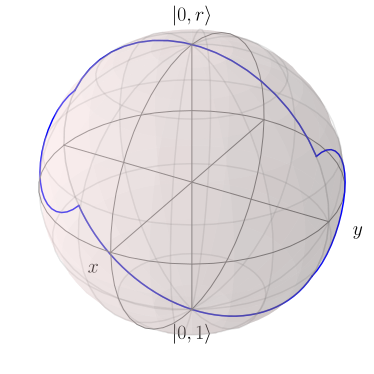

In [ ]:
psi_ai = basis(8, 1)
psi_a1 = [
    (-1j * H(1, 0) * (np.pi / 2 / np.sqrt(2)) * t).expm() * psi_ai
    for t in np.linspace(0, 1, 20)
]
psi_a2 = [
    (-1j * H(0, 1) * np.pi * t).expm() * psi_a1[-1] for t in np.linspace(0, 1, 20)
]
psi_a3 = [
    (-1j * H(1, 0) * (np.pi / np.sqrt(2)) * t).expm() * psi_a2[-1]
    for t in np.linspace(0, 1, 20)
]
psi_a4 = [
    (-1j * H(0, 1) * (np.pi) * t).expm() * psi_a3[-1] for t in np.linspace(0, 1, 20)
]
psi_a5 = [
    (-1j * H(1, 0) * (np.pi / 2 / np.sqrt(2)) * t).expm() * psi_a4[-1]
    for t in np.linspace(0, 1, 20)
]

bloch_a = Bloch()
bloch_a.add_points(
    [expect(sigax, psi_a1), expect(sigay, psi_a1), expect(sigaz, psi_a1)], meth="l"
)
bloch_a.add_points(
    [expect(sigax, psi_a2), expect(sigay, psi_a2), expect(sigaz, psi_a2)], meth="l"
)
bloch_a.add_points(
    [expect(sigax, psi_a3), expect(sigay, psi_a3), expect(sigaz, psi_a3)], meth="l"
)
bloch_a.add_points(
    [expect(sigax, psi_a4), expect(sigay, psi_a4), expect(sigaz, psi_a4)], meth="l"
)
bloch_a.add_points(
    [expect(sigax, psi_a5), expect(sigay, psi_a5), expect(sigaz, psi_a5)], meth="l"
)
bloch_a.point_color = "b"

bloch_a.zlabel = [r"$\left|0,r\right>$", r"$\left|0,1\right>$"]
bloch_a.show()

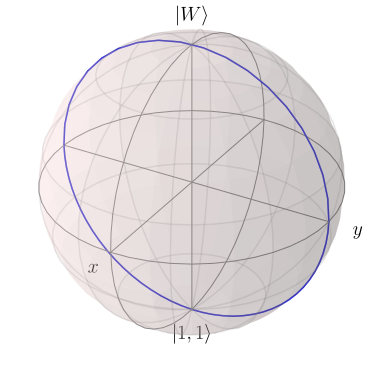

In [ ]:
psi_bi = basis(8, 5)
psi_b1 = [
    (-1j * H(1, 0) * (np.pi / 2 / np.sqrt(2)) * t).expm() * psi_bi
    for t in np.linspace(0, 1, 20)
]
psi_b2 = [
    (-1j * H(0, 1) * np.pi * t).expm() * psi_b1[-1] for t in np.linspace(0, 1, 20)
]
psi_b3 = [
    (-1j * H(1, 0) * (np.pi / np.sqrt(2)) * t).expm() * psi_b2[-1]
    for t in np.linspace(0, 1, 20)
]
psi_b4 = [
    (-1j * H(0, 1) * (np.pi) * t).expm() * psi_b3[-1] for t in np.linspace(0, 1, 20)
]
psi_b5 = [
    (-1j * H(1, 0) * (np.pi / 2 / np.sqrt(2)) * t).expm() * psi_b4[-1]
    for t in np.linspace(0, 1, 20)
]

bloch_b = Bloch()
bloch_b.add_points(
    [expect(sigbx, psi_b1), expect(sigby, psi_b1), expect(sigbz, psi_b1)], meth="l"
)
bloch_b.add_points(
    [expect(sigbx, psi_b2), expect(sigby, psi_b2), expect(sigbz, psi_b2)], meth="l"
)
bloch_b.add_points(
    [expect(sigbx, psi_b3), expect(sigby, psi_b3), expect(sigbz, psi_b3)], meth="l"
)
bloch_b.add_points(
    [expect(sigbx, psi_b4), expect(sigby, psi_b4), expect(sigbz, psi_b4)], meth="l"
)
bloch_b.add_points(
    [expect(sigbx, psi_b5), expect(sigby, psi_b5), expect(sigbz, psi_b5)], meth="l"
)
bloch_b.point_color = "b"
bloch_b.zlabel = [r"$\left|W\right>$", r"$\left|1,1\right>$"]
bloch_b.show()

### **d. [5 points]**  

For the noisy case, can you plot the state preparation fidelity $F(\epsilon) = \left| \braket{\psi_f(0)}{\psi_f(\epsilon)} \right|^2$ as $\epsilon$ varies? In the $\epsilon \ll 1$ regime, we have $(1 - F) \propto \epsilon^n$, can you determine what $n$ is?

---

(solved together with part (e), see below)

### **e. [5 points]**  

The authors claimed that their gate has “conditional robustness”, that is, we can improve the fidelity by performing measurement and keep the part which lies in the computational subspace $\{\ket{0}, \ket{1} \}^{\otimes 2}$. This means finally we have

$$
\rho_C(\epsilon) = \frac{P_C \ket{\psi_f(\epsilon)} \bra{\psi_f(\epsilon)} P_C}{\bra{\psi_f(\epsilon)} P_C \ket{\psi_f(\epsilon)}}
\tag{2}
$$

where $P_C = \ket{00}\bra{00} + \ket{01}\bra{01} + \ket{10}\bra{10} + \ket{11}\bra{11}$.

Can you plot 

$$
F_C(\epsilon) = \bra{\psi_f(0)} \rho_C(\epsilon) \ket{\psi_f(0)}
$$ 

as $\epsilon$ changes? In $\epsilon \ll 1$ limit, $(1 - F_C) \propto \epsilon^{n'}$, can you find $n'$?

---

In [ ]:
### 2.4 Fidelity when there is amplitude error
eps_list = np.linspace(0, 0.2, 100)
fid = [expect(ket2dm(psi_fnl), U(eps) * psi_ini) for eps in eps_list]

In [ ]:
### 2.5 Fidelity after post-selection
proj = (
    ket2dm(basis(8, 0))
    + ket2dm(basis(8, 1))
    + ket2dm(basis(8, 3))
    + ket2dm(basis(8, 5))
)
fid_2 = [
    expect(ket2dm(psi_fnl), proj * U(eps) * psi_ini)
    / expect(qeye(8), proj * U(eps) * psi_ini)
    for eps in eps_list
]

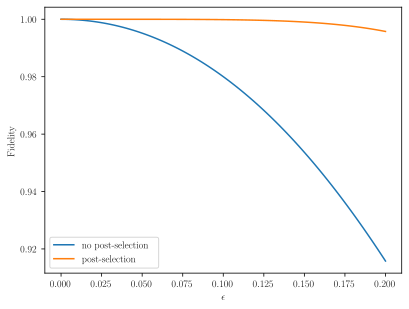

In [ ]:
plt.plot(eps_list, fid, label="no post-selection")
plt.plot(eps_list, fid_2, label="post-selection")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Fidelity")
plt.legend()
plt.show()

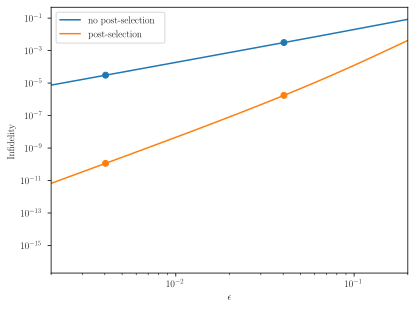

In [ ]:
### Use the log-log plot to estimate the scaling, which is shown as the slope
### Let's pick some points to calculate that
plt.loglog(eps_list, 1 - np.array(fid), label="no post-selection")
plt.loglog(eps_list, 1 - np.array(fid_2), label="post-selection")

plt.scatter(eps_list[2], 1 - np.array(fid[2]), c="C0")
plt.scatter(eps_list[20], 1 - np.array(fid[20]), c="C0")
plt.scatter(eps_list[2], 1 - np.array(fid_2[2]), c="C1")
plt.scatter(eps_list[20], 1 - np.array(fid_2[20]), c="C1")

plt.xlim(2e-3, 2e-1)

plt.xlabel(r"$\epsilon$")
plt.ylabel("Infidelity")
plt.legend()
plt.show()

In [ ]:
n = (np.log(1 - fid[20]) - np.log(1 - fid[2])) / (
    np.log(eps_list[20]) - np.log(eps_list[2])
)
n_pr = (np.log(1 - fid_2[20]) - np.log(1 - fid_2[2])) / (
    np.log(eps_list[20]) - np.log(eps_list[2])
)

print(n)
print(n_pr)

2.009076892293879
4.184082656775772


It seems that For the no post-selection case, $1-F \propto \epsilon^2$, while for the post-selection case $1-F \propto \epsilon^4$.

### **f. [5 points]**  

In **Sec. IV.A.2** the authors propose another sequence to achieve “fully robust protocol” by applying two controlled-$(\frac{\pi}{2})$ gates sequentially (**FIG. 2**). Please first intuitively explain why the generalization shown in **FIG. 2** gives controlled-$(\frac{\pi}{2})$ gates and can be further generalized to controlled-$(\theta)$ gate with arbitrary $\theta$.

Then repeat what you did in part (d) with the “fully robust” CZ gate suffering from amplitude error $\epsilon$. Specifically, how does 

$$
F(\epsilon) = \left| \langle \psi_f(0) | \psi_f(\epsilon) \rangle \right|^2
$$ 

depend on $\epsilon$ now? What is the scaling factor $n$ in $(1 - F) \propto \epsilon^n$?

---


In [ ]:
def U2(eps):
    Ux1 = (-1j * H(1, 0) * (np.pi / 2 / np.sqrt(2)) * (1 + eps)).expm()
    Uy1 = (-1j * H(0, 1) * np.pi * (1 + eps)).expm()
    Uy2 = (-1j * H(0, 1) * (np.pi / 2 / np.sqrt(2)) * (1 + eps)).expm()
    Ux2 = (-1j * H(-1, 0) * np.pi * (1 + eps)).expm()
    return ((Uy2 * Ux2 * Uy2) * (Ux1 * Uy1 * Ux1)) ** 2

In [27]:
U2(0) * psi_ini

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 5.00000000e-01]
 [-5.00000000e-01]
 [ 7.41026799e-49]
 [-5.00000000e-01]
 [ 7.41026799e-49]
 [-5.00000000e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]

Text(0, 0.5, 'Fidelity')

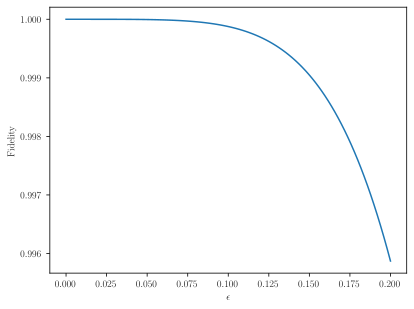

In [ ]:
eps_list = np.linspace(0, 0.2, 100)
fid_3 = [expect(ket2dm(psi_fnl), U2(eps) * psi_ini) for eps in eps_list]

plt.plot(eps_list, fid_3)
plt.xlabel(r"$\epsilon$")
plt.ylabel("Fidelity")

(0.002, 0.2)

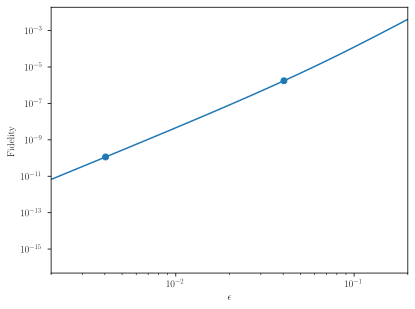

In [ ]:
plt.loglog(eps_list, 1 - np.array(fid_3))
plt.scatter(eps_list[2], 1 - np.array(fid_3[2]), c="C0")
plt.scatter(eps_list[20], 1 - np.array(fid_3[20]), c="C0")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Fidelity")
plt.xlim(2e-3, 2e-1)

In [ ]:
n_3 = (np.log(1 - fid_3[20]) - np.log(1 - fid_3[2])) / (
    np.log(eps_list[20]) - np.log(eps_list[2])
)
print(n_3)

4.184353414676203


The scaling still gives roughly $1-F \propto \epsilon^4$.